#### Compute dSPM inverse solution on single trial epochs restricted to a brain label.

In [2]:
from mne.minimum_norm import apply_inverse_epochs,read_inverse_operator
from mne.minimum_norm import apply_inverse

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import sample

In [4]:
data_path = sample.data_path()
fname_inv = data_path + '/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif'
fname_raw = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
fname_event = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
label_name = 'Aud-lh'
fname_label = data_path + '/MEG/sample/labels/%s.label' % label_name

In [5]:
event_id, tmin, tmax = 1, -0.2, 0.5

# Using the same inverse operator when inspecting single trials Vs. evoked
snr = 3.0  # Standard assumption for average data but using it for single trial
lambda2 = 1.0 / snr ** 2

method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

In [6]:
# load data
inverse_operator = read_inverse_operator(fname_inv)
label = mne.read_label(fname_label)
raw = mne.io.read_raw_fif(fname_raw)
events = mne.read_events(fname_event)

Reading inverse operator decomposition from /home/reallocing/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computin

In [19]:
label.pos

array([[-0.02174, -0.01283, -0.01217],
       [-0.02165, -0.01262, -0.01242],
       [-0.02133, -0.01223, -0.01194],
       ..., 
       [-0.02196,  0.01411, -0.02296],
       [-0.02242,  0.01382, -0.02308],
       [-0.02276,  0.01343, -0.02312]])

In [20]:
# Set up pick list
include = []
raw.info['bads'] += ['EEG 053']

In [22]:
# pick MEG channels
picks = mne.pick_types(raw.info,meg=True,eeg=False,stim=False,eog=True,include=include,exclude='bads')

In [24]:
# read epochs
epochs = mne.Epochs(raw,events,event_id,tmin,tmax,picks=picks,baseline=(None,0),reject=dict(mag=4e-12,grad=4000e-13,eog=150e-6))

72 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 3)
4 projection items activated


In [25]:
# Get evoked data (averaging across trials in sensor space)
evoked = epochs.average()

    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on MAG : [u'MEG 1711']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']


In [27]:
# Compute inverse solution and stcs for each epoch
# Use the same inverse operator as with evoked data (i.e., set nave)
# If you use a different nave, dSPM just scales by a factor sqrt(nave)
stcs = apply_inverse_epochs(epochs,inverse_operator,lambda2,method,label,pick_ori='normal',nave=evoked.nave)
stc_evoked = apply_inverse(evoked,inverse_operator,lambda2,method,pick_ori='normal')

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 55
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 305 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing epoch : 9
Processing epoch : 10
    Rejecting  epoch based on EOG : [u'EOG 061']
Processing epoch : 11
Processing epoch : 12
Processing epoch : 13
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
Processing epoch : 14
Processing epoch : 15
Processing epoch : 16
Processing epoch : 17
    Rejecting  epoch based on EOG : 

In [28]:
stc_evoked_label = stc_evoked.in_label(label)

In [29]:
stc_evoked_label

<SourceEstimate  |  33 vertices, subject : sample, tmin : -199.795213158 (ms), tmax : 499.488032896 (ms), tstep : 6.65984043861 (ms), data shape : (33, 106)>

In [31]:
# Mean across trials but not across vertices in label
mean_stc = sum(stcs) / len(stcs)

# compute sign flip to avoid signal cancellation when averaging signed values
flip = mne.label_sign_flip(label, inverse_operator['src'])

label_mean = np.mean(mean_stc.data, axis=0)
label_mean_flip = np.mean(flip[:, np.newaxis] * mean_stc.data, axis=0)

# Get inverse solution by inverting evoked data
stc_evoked = apply_inverse(evoked, inverse_operator, lambda2, method,
                           pick_ori="normal")

# apply_inverse() does whole brain, so sub-select label of interest
stc_evoked_label = stc_evoked.in_label(label)

# Average over label (not caring to align polarities here)
label_mean_evoked = np.mean(stc_evoked_label.data, axis=0)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 55
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 305 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  59.3% variance
    dSPM...
[done]


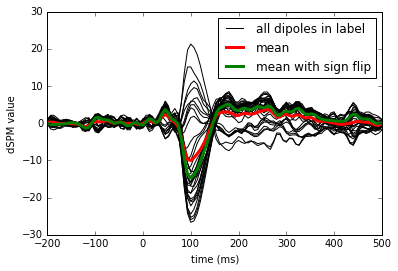

In [32]:
## View activation time-series to illustrate the benefit of aligning/flipping
times = 1e3 * stcs[0].times  # times in ms

plt.figure()
h0 = plt.plot(times, mean_stc.data.T, 'k')
h1, = plt.plot(times, label_mean, 'r', linewidth=3)
h2, = plt.plot(times, label_mean_flip, 'g', linewidth=3)
plt.legend((h0[0], h1, h2), ('all dipoles in label', 'mean',
                             'mean with sign flip'))
plt.xlabel('time (ms)')
plt.ylabel('dSPM value')
plt.show()